## Import Libraries

In [1]:
from coinbase.wallet.client import Client
import cbpro

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## Connect to API for my Account

In [2]:
import config
client = Client(config.apiKey, config.apiSecret, api_version = config.apiVersion)

btcCurrencyPair = 'ETH-USD'

price = client.get_spot_price(currency_pair = btcCurrencyPair)
price

<APIObject @ 0x1f71a898e50> {
  "amount": "1383.83",
  "base": "ETH",
  "currency": "USD"
}

## Useful Functions

In [3]:
def UnixToDate(time): 
    return datetime.fromtimestamp(time)

In [4]:
def isGranularityOption(g):
    #1 min, 5 min, 15 min, 1 hr, 6 hrs, 1 day
    possibleGranularities = [60, 300, 900, 3600, 21600, 86400] 
    return (g in possibleGranularities)

In [5]:
from datetime import datetime
def unixToISO8601(unixTime):
    t =  int(unixTime)
    return str(datetime.fromtimestamp(t).isoformat())

In [6]:
def x_YearsAgoInUnixTime(years):
    today = int(time.time())
    secodnsPerYear = 31536000
    return (today - (years*secodnsPerYear))
def x_MonthsAgoInUnixTime(months):
    today = int(time.time())
    secodnsPerMonth = 2628000 #average sec/month
    return (today - (months*secodnsPerMonth))
def x_DaysAgoInUnixTime(days):
    today = int(time.time())
    secodnsPerDay = 86400
    return (today - (days*secodnsPerDay))

In [7]:
#API will only return 300 bins at once so if you input a big range you will need to call API multiple times
def calcNumberofCallsNeeded(startTime_unix, endTime_unix, granularity):
    maxBins = 300
    maxTime = maxBins * granularity
    if maxTime < endTime_unix - startTime_unix:
        return ((endTime_unix - startTime_unix)//maxTime) + 1 #add 1 cause we want ceiling(x)
    else:
        return 1

In [8]:
#takes ticker and granularity and a start and end time and returns a dataFrame of the data
import time
def getData(tickerPair, granularity, startTime_unix, endTime_unix = int(time.time())):
    if isGranularityOption(granularity) and endTime_unix > startTime_unix:  
        numCalls = calcNumberofCallsNeeded(startTime_unix,endTime_unix, granularity)

        data = []
        isoStart = unixToISO8601(startTime_unix)
        isoEnd = unixToISO8601(endTime_unix)
        if numCalls == 1:
            data = public_client.get_product_historic_rates(tickerPair, isoStart, isoEnd, granularity)
        else:
            for i in range(numCalls + 1):
                currentStep = 300*i*granularity #300 is max bins coinbase API will return at once
                isoStart = unixToISO8601(endTime_unix-currentStep)
                temp = public_client.get_product_historic_rates(tickerPair, isoStart, isoEnd, granularity)
                isoEnd = isoStart
                for element in temp: #data is 2D so loop to append, make prettier later
                    data.append(element)
           
        df = pd.DataFrame(data, columns=['date', 'open', 'high', 'low', 'close','volume'])
        df.set_index('date', inplace=True)
        return df.iloc[::-1] #reverse order so its chronological
    else:
        print("Input error, use one of the following granularity values [60, 300, 900, 3600, 21600, 86400]\
        and make sure the start time is before the end time")
        return None

In [9]:
import plotly.graph_objects as go
def plotCandles(df):
    
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                    open=df['open'],
                    high=df['high'],
                    low=df['low'],
                    close=df['close'])])
    fig.show()

In [10]:
def plotLine(df,ticker):
    fig = plt.figure(1,figsize=(8, 5))
    plt.plot(df['close'],label = ticker)
    plt.xlabel("Unix Time")
    plt.ylabel("Price-USD")
    start = UnixToDate(df.index[-1])
    end = UnixToDate(df.index[0])
    plt.title("{}-USD from {} to {}".format(ticker,start,end))
    plt.legend()
    return fig

## Trade Indicator Functions

#### 1) RSI - Can be calculate with SMA or EMA

In [11]:
#given a dataframe it will calculate the RSI for each candle
def relativeStrengthIndex(df, granularity = 86400, lookbackPeriod = 14, funcType = "SMA"):

    data = df.drop('volume',axis = 1)
    data["RSI"] = np.nan
    data['change'] = data['close'].diff(1)
    if funcType == "SMA":
        data['RSI'] = data['change'].rolling(window=lookbackPeriod).apply(relativeStrengthIndexHelperSMA)
    elif funcType == "EMA":
        posChanges = data['change'].mask(data['change'] < 0, other = 0) #use mask to maintain length
        negChanges =  data['change'].mask(data['change'] > 0, other = 0) 
        upEWM = posChanges.ewm(com=lookbackPeriod-1,min_periods = lookbackPeriod).mean()
        downEWM = negChanges.ewm(com=lookbackPeriod-1,min_periods = lookbackPeriod).mean()
        relativeStrength = abs(upEWM/downEWM)
        data['RSI'] = (100 - (100/(1 + relativeStrength)))
    else:
        print("Not a valid RSI function type")
        return None
    
    return data['RSI'] #subject to change not sure how I'm going to use, maybe just edit initial df and dont delete volume

def relativeStrengthIndexHelperSMA(period): #period is last n changes in closing price
    avgOfPositives = np.mean(period[period > 0])
    avgOfNegatives = np.mean(period[period < 0])
    relativeStrength =  abs(avgOfPositives/avgOfNegatives)
    return (100 - (100/(1 + relativeStrength)))




## Example -- BTC Data

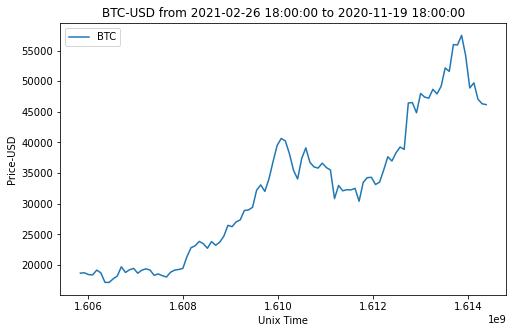

In [12]:
public_client = cbpro.PublicClient()

#careful, can overflow memory and break if you get too much data
granularity = 86400
btc = getData("BTC-USD", granularity, x_DaysAgoInUnixTime(100)) 
fig = plotLine(btc,"BTC")


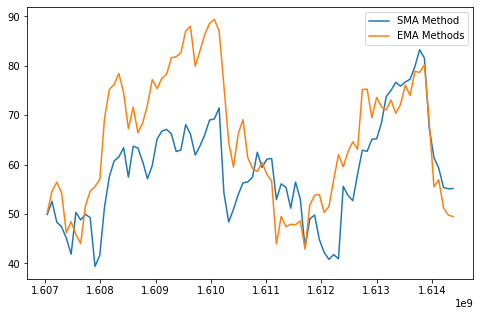

In [13]:
plt.figure(2,figsize=(8, 5))
SMA = relativeStrengthIndex(btc)
EMA = relativeStrengthIndex(btc, funcType = "EMA")
plt.plot(SMA,label="SMA Method")
plt.plot(EMA,label="EMA Method")
plt.legend()